In [1]:
import numpy as np
import csv
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
from sklearn.model_selection import train_test_split
 #首先，读取.CSV文件成矩阵的形式。
my_matrix = np.loadtxt(open("results.csv"),delimiter=",",skiprows=0)
#print(my_matrix)
 #对于矩阵而言，将矩阵倒数第一列之前的数值给了X（输入数据），将矩阵大最后一列的数值给了y（标签）
X, y = my_matrix[:,:-1],my_matrix[:,-1]
 #利用train_test_split方法，将X,y随机划分问，训练集（X_train），训练集标签（X_test），测试卷（y_train），
 #测试集标签（y_test），安训练集：测试集=7:3的
 #概率划分，到此步骤，可以直接对数据进行处理
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)
 #此步骤，是为了将训练集与数据集的数据分别保存为CSV文件
 #np.column_stack将两个矩阵进行组合连接
train= np.column_stack((X_train,y_train))
 #numpy.savetxt 将txt文件保存为.csv结尾的文件
np.savetxt('train_usual.csv',train, delimiter = ',')
test = np.column_stack((X_test, y_test))
np.savetxt('test_usual.csv', test, delimiter = ',')

In [3]:
torch_x = torch.from_numpy(X_train)
torch_y = torch.from_numpy(y_train)
test_x = torch.from_numpy(X_test)
test_y = torch.from_numpy(y_test)
y_train = torch.tensor(torch_y, dtype=torch.long)
y_test = torch.tensor(test_y,dtype = torch.long)
x_test = torch.tensor(test_x , dtype=torch.float32)
x_train = torch.tensor(torch_x, dtype=torch.float32)

/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

In [4]:
#Hyper parameters
EPOCH = 50
BATCH_SIZE = 100
TIME_STEP = 20
INPUT_SIZE = 60
LR = 0.001

In [5]:
#x_test = x_test.reshape(x_test.shape[0], TIME_STEP, INPUT_SIZE)
#x_train = x_train.reshape(x_train.shape[0], TIME_STEP, INPUT_SIZE)
print(x_train.shape,x_test.shape)
train_data = Data.TensorDataset(x_train,y_train )
train_loader = Data.DataLoader(dataset= train_data, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
print(x_train,x_test)

torch.Size([1025, 1200]) torch.Size([114, 1200])
tensor([[0.0333, 0.0317, 0.0304,  ..., 0.0151, 0.0129, 0.0161],
        [0.0119, 0.0170, 0.0246,  ..., 0.0111, 0.0134, 0.0166],
        [0.0429, 0.0343, 0.0259,  ..., 0.0076, 0.0102, 0.0150],
        ...,
        [0.0456, 0.0472, 0.0483,  ..., 0.0128, 0.0140, 0.0192],
        [0.0416, 0.0392, 0.0472,  ..., 0.0307, 0.0333, 0.0363],
        [0.0653, 0.0614, 0.0635,  ..., 0.0022, 0.0017, 0.0036]]) tensor([[0.0690, 0.0735, 0.0760,  ..., 0.0035, 0.0072, 0.0122],
        [0.0285, 0.0342, 0.0391,  ..., 0.0307, 0.0274, 0.0306],
        [0.0239, 0.0192, 0.0157,  ..., 0.0356, 0.0337, 0.0294],
        ...,
        [0.0710, 0.0686, 0.0686,  ..., 0.0411, 0.0459, 0.0432],
        [0.0225, 0.0306, 0.0372,  ..., 0.0323, 0.0371, 0.0421],
        [0.0657, 0.0741, 0.0860,  ..., 0.0338, 0.0365, 0.0344]])


In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(20*60, 1200),
            nn.LeakyReLU(),
            nn.Linear(1200,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,768),
            nn.LeakyReLU(),
            nn.Linear(768,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,3),  # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 256),
            nn.LeakyReLU(),
            nn.Linear(256,512),
            nn.LeakyReLU(),
            nn.Linear(512, 768),
            nn.LeakyReLU(),
            nn.Linear(768,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,1200),
            nn.LeakyReLU(),
            nn.Linear(1200, 20*60),
            #nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
autoencoder =  AutoEncoder()
#print(rnn)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
loss_func = torch.nn.MSELoss()

In [8]:
Loss_encoder = []
Times = []
times = 1
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(x)   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        Loss_encoder.append(loss)
        Times.append(times)
        times += 1

        if step % 100 == 0 :
            test_encoded, test_decoded = autoencoder(x_test)
            test_loss = loss_func(test_decoded,x_test)
            print('Epoch: ', epoch, '| train loss: %.8f' % loss.data,'| test loss:%.8f' % test_loss.data)
            


Epoch:  0 | train loss: 0.00911041 | test loss:0.00697312
Epoch:  1 | train loss: 0.00251275 | test loss:0.00264743
Epoch:  2 | train loss: 0.00147029 | test loss:0.00143373
Epoch:  3 | train loss: 0.00135182 | test loss:0.00136641
Epoch:  4 | train loss: 0.00134064 | test loss:0.00136412
Epoch:  5 | train loss: 0.00129797 | test loss:0.00135342
Epoch:  6 | train loss: 0.00143435 | test loss:0.00131275
Epoch:  7 | train loss: 0.00118478 | test loss:0.00118055
Epoch:  8 | train loss: 0.00109100 | test loss:0.00108689
Epoch:  9 | train loss: 0.00096126 | test loss:0.00104072
Epoch:  10 | train loss: 0.00102356 | test loss:0.00103828
Epoch:  11 | train loss: 0.00089891 | test loss:0.00096730
Epoch:  12 | train loss: 0.00084148 | test loss:0.00097123
Epoch:  13 | train loss: 0.00086644 | test loss:0.00091698
Epoch:  14 | train loss: 0.00079577 | test loss:0.00091984
Epoch:  15 | train loss: 0.00079869 | test loss:0.00088742
Epoch:  16 | train loss: 0.00084457 | test loss:0.00080828
Epoch: 

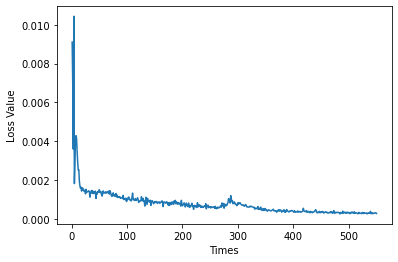

In [9]:
plt.plot(Times,Loss_encoder)
plt.xlabel('Times')
plt.ylabel('Loss Value')
plt.savefig('Encoder_loss.tif', dpi = 400)
plt.show()
np.save('Loss_encoder.npy', Loss_encoder)

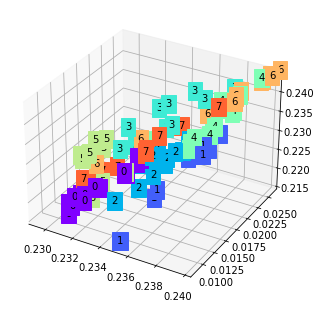

In [10]:
view_data = Variable(x_train[:100].type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(1); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = y_train[:100].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/8)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())

plt.savefig("encoded.tif",dpi = 400)
plt.show()


In [ ]:
b_x = Variable(x_train[0])   # batch x, shape (batch, 28*28)
encoded, decoded = autoencoder(b_x)
print(b_x,encoded.data)

In [ ]:
encoded_train_data, _ = autoencoder(x_train)
encoded_test_data, _ = autoencoder(x_test)
encoded_train_data = encoded_train_data.data.numpy()
encoded_test_data = encoded_test_data.data.numpy()
encoded_train_data = torch.tensor(encoded_train_data, dtype=torch.float32)
encoded_test_data = torch.tensor(encoded_test_data, dtype=torch.float32)
print(encoded_train_data)

In [ ]:
encoded_train_data, _ = autoencoder(x_train)
encoded_test_data, _ = autoencoder(x_test)
encoded_train_data = encoded_train_data.data.numpy()
encoded_test_data = encoded_test_data.data.numpy()
encoded_train_data1 = pd.DataFrame(encoded_train_data)
encoded_test_data1 = pd.DataFrame(encoded_test_data)
y_train1 = pd.DataFrame(y_train)
y_test1 = pd.DataFrame(y_test)
y_train1.to_csv(r"y_train.csv", header=False, index=False)
y_test1.to_csv(r"y_test.csv", header=False, index=False)
encoded_train_data1.to_csv(r"encoded_train_data.csv", header=False, index=False)
encoded_test_data1.to_csv(r"encoded_test_data.csv", header=False, index=False)
print(encoded_train_data1.shape)

In [ ]:
#print(encoded_train_data.data.numpy())
#Hyper parameters
EPOCH = 10
BATCH_SIZE = 8
LR = 0.001

In [ ]:
encoded_train_data = encoded_train_data.reshape(encoded_train_data.shape[0], 8,8)
encoded_test_data = encoded_test_data.reshape(encoded_test_data.shape[0],8,8)
print(encoded_train_data.shape)
torch_dataset = Data.TensorDataset(encoded_train_data,y_train )
train_loader = Data.DataLoader(dataset= torch_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv1d(
                in_channels=8,              # input height
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                                            # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            #nn.MaxPool1d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv1d(16, 32, 3, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            #nn.MaxPool1d(2),                # output shape (32, 7, 7)
        )

        self.out = nn.Linear(128, 8)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr = LR)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            train_output, last_layer = cnn(encoded_train_data)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            accuracy = (pred_y == y_train).sum().item() / float(y_train.size(0))
            print('epoch:'+ str(epoch) + 'loss:'+ str(loss)+'|train accuracy:' + str(accuracy) )

            
            
            

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=8,
            hidden_size=64,         # rnn hidden unit
            num_layers=3,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 8)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [ ]:
rnn =  RNN()
#print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr = LR)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x.view(-1,8,8))   # batch x
        b_y = Variable(y)   # batch y
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            train_output = rnn(encoded_train_data)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            train_accuracy = (pred_y == y_train).sum().item() / float(y_train.size(0))
            test_output = rnn(encoded_test_data)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (pred_y == y_test).sum().item() / float(y_test.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data,'| train accuracy: %.2f' % train_accuracy, '| test accuracy: %.2f' % test_accuracy)
        
        
        